In [49]:
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import pandas as pd
import sqlite3
import DataFunctions
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '3WCU5V2X05Rvh60ZxUG8FarJN4s2D1lcd2c2r6Kz/qL1Y3tVBJtWsuNATnzHRV2h'
configuration.api_key_prefix['Authorization'] = 'Bearer'

## Data Preprocessing

Games DF

In [2]:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
year=2022
division="fbs"

# no longer need, right?
# try:
#     api_response = api_instance.get_games(year=year,division=division)
#     print(len(api_response))
# except:
#     print(ApiException)
    

In [3]:
gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=2022)
# len(gamelist)

In [4]:
games_df = DataFunctions.df_from_games(gamelist=gamelist)
# games_df.head()

In [5]:
# conn = sqlite3.connect("CollegeFootball.db")
# games_df.to_sql("games",conn,if_exists="replace",index=False)
# conn.close()


In [6]:
# we can see with this code that we can extract DF from SQL db

# conn = sqlite3.connect("CollegeFootball.db")
# trialdf = pd.read_sql_query("SELECT * FROM games",conn)
# conn.close()
# print(trialdf.shape)
# trialdf.head()


Betting lines DF

In [7]:
api_instance1 = cfbd.BettingApi(cfbd.ApiClient(configuration))

In [8]:
conferences=[]
for game in gamelist:
    conferences.append(game.away_conference)
conferences=set(conferences)

conferences

{'ACC',
 'American Athletic',
 'Big 12',
 'Big Ten',
 'Conference USA',
 'FBS Independents',
 'Mid-American',
 'Mountain West',
 'Pac-12',
 'SEC',
 'Sun Belt'}

In [9]:
betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=2022,conferences=conferences)

In [10]:
betting_df=DataFunctions.df_betting_lines(betting_list)
betting_df

#warning seems to be since betting line -0.0 for one of the games but still stores value as 0 so should be fine

,id,av_spread,av_total
0,401411101,-24.375,51.375
1,401404079,7.125,65.625
2,401403893,1.500,51.000
3,401404080,2.500,45.000
4,401404081,13.625,53.000
...,...,...,...
733,401404090,-7.500,65.250
734,401404011,-3.125,64.500
735,401404012,12.375,64.500
736,401404088,-1.125,45.000


In [11]:
# conn=sqlite3.connect("CollegeFootball.db")
# betting_df.to_sql("betting_lines",conn,if_exists="replace",index=False)
# conn.close()

In [12]:
# #sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

Team stats per season DF

In [13]:
api_instance2 = cfbd.StatsApi(cfbd.ApiClient(configuration))

In [14]:
teamstats = api_instance2.get_advanced_team_season_stats(year=year)

In [15]:
stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)

In [16]:
stats_df.columns

Index(['team', 'season', 'conference', 'Offensive_plays', 'Offensive_drives',
       'Offensive_ppa', 'Offensive_total_ppa', 'Offensive_success_rate',
       'Offensive_explosiveness', 'Offensive_power_success',
       'Offensive_stuff_rate', 'Offensive_line_yards',
       'Offensive_line_yards_total', 'Offensive_second_level_yards',
       'Offensive_second_level_yards_total', 'Offensive_open_field_yards',
       'Offensive_open_field_yards_total', 'Offensive_total_opportunies',
       'Offensive_points_per_opportunity', 'Defensive_plays',
       'Defensive_drives', 'Defensive_ppa', 'Defensive_total_ppa',
       'Defensive_success_rate', 'Defensive_explosiveness',
       'Defensive_power_success', 'Defensive_stuff_rate',
       'Defensive_line_yards', 'Defensive_line_yards_total',
       'Defensive_second_level_yards', 'Defensive_second_level_yards_total',
       'Defensive_open_field_yards', 'Defensive_open_field_yards_total',
       'Defensive_total_opportunies', 'Defensive_points_p

In [17]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']
stats_df1 = DataFunctions.df_stats_needed(stats_df,cols)

In [18]:
stats_df1.shape

(131, 29)

In [19]:
stats_df1.head()

,team,season,conference,Offensive_ppa,Offensive_success_rate,Offensive_explosiveness,Offensive_power_success,Offensive_stuff_rate,Offensive_line_yards,Defensive_ppa,...,Offensive_passing_plays_ppa,Offensive_passing_plays_success_rate,Offensive_passing_plays_explosiveness,Defensive_havoc_total,Defensive_rushing_plays_ppa,Defensive_rushing_plays_success_rate,Defensive_rushing_plays_explosiveness,Defensive_passing_plays_ppa,Defensive_passing_plays_success_rate,Defensive_passing_plays_explosiveness
0,Air Force,2022,Mountain West,0.297878,0.480570,1.132888,0.825000,0.093979,3.557269,0.123016,...,0.505886,0.382022,2.614222,0.196944,0.097045,0.394737,0.969436,0.255682,0.425455,1.410758
1,Akron,2022,Mid-American,0.113974,0.426016,1.185226,0.735294,0.154185,3.144493,0.269248,...,0.231801,0.418848,1.459991,0.199301,0.156959,0.446541,1.005307,0.449689,0.480000,1.656349
2,Alabama,2022,SEC,0.305324,0.471508,1.375730,0.722222,0.194954,2.970183,0.028379,...,0.394611,0.479303,1.637813,0.180089,0.078791,0.407583,0.952710,0.012309,0.348936,1.379126
3,Appalachian State,2022,Sun Belt,0.259159,0.456019,1.295246,0.705882,0.127660,3.395532,0.205438,...,0.311707,0.427835,1.704787,0.170267,0.136812,0.402062,1.053082,0.313190,0.430025,1.543410
4,Arizona,2022,Pac-12,0.271661,0.472081,1.379341,0.673469,0.171875,3.326875,0.351341,...,0.370241,0.448578,1.726454,0.130807,0.338295,0.559036,0.998885,0.389756,0.501253,1.398465


In [20]:
# We use this to insert api_responses to SQL database
# 
# 
# for year in range(2015,2023):
#     gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=year)
#     games_df = DataFunctions.df_from_games(gamelist=gamelist)
    
#     betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=year,conferences=conferences)
#     betting_df=DataFunctions.df_betting_lines(betting_list)
    
#     teamstats = api_instance2.get_advanced_team_season_stats(year=year)
#     stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)
#     stats_df = DataFunctions.df_stats_needed(stats_df,cols)
    
#     conn = sqlite3.connect("CollegeFootball.db")
#     games_df.to_sql("games",conn,if_exists="append",index=False)
#     betting_df.to_sql("betting_lines",conn,if_exists="append",index=False)
#     stats_df.to_sql("stats",conn,if_exists="append",index=False)
    
#     conn.close()
    

In [21]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']

In [22]:
cols = cols[3:]

In [23]:
cols

['Offensive_ppa',
 'Offensive_success_rate',
 'Offensive_explosiveness',
 'Offensive_power_success',
 'Offensive_stuff_rate',
 'Offensive_line_yards',
 'Defensive_ppa',
 'Defensive_success_rate',
 'Defensive_explosiveness',
 'Defensive_power_success',
 'Defensive_stuff_rate',
 'Defensive_line_yards',
 'Offensive_havoc_total',
 'Offensive_rushing_plays_ppa',
 'Offensive_rushing_plays_success_rate',
 'Offensive_rushing_plays_explosiveness',
 'Offensive_passing_plays_ppa',
 'Offensive_passing_plays_success_rate',
 'Offensive_passing_plays_explosiveness',
 'Defensive_havoc_total',
 'Defensive_rushing_plays_ppa',
 'Defensive_rushing_plays_success_rate',
 'Defensive_rushing_plays_explosiveness',
 'Defensive_passing_plays_ppa',
 'Defensive_passing_plays_success_rate',
 'Defensive_passing_plays_explosiveness']

In [24]:
gcols = games_df.columns
gstr = ""
for c in gcols:
    gstr += "G."+str(c)+","

gstr

'G.id,G.season,G.neutral_site,G.home_id,G.home_team,G.home_conference,G.home_points,G.away_id,G.away_team,G.away_conference,G.away_points,G.game_spread,G.game_totalpts,'

In [25]:
bcols = betting_df.columns
bstr = ""
for b in bcols:
    bstr += "B."+str(b)+","
bstr = bstr[5:]

In [26]:
s1 = ""
for c in cols:
   s1 += "S1." + str(c) +  " AS Home_" + str(c) + ", "

s1 = s1[:-1]
s1

'S1.Offensive_ppa AS Home_Offensive_ppa, S1.Offensive_success_rate AS Home_Offensive_success_rate, S1.Offensive_explosiveness AS Home_Offensive_explosiveness, S1.Offensive_power_success AS Home_Offensive_power_success, S1.Offensive_stuff_rate AS Home_Offensive_stuff_rate, S1.Offensive_line_yards AS Home_Offensive_line_yards, S1.Defensive_ppa AS Home_Defensive_ppa, S1.Defensive_success_rate AS Home_Defensive_success_rate, S1.Defensive_explosiveness AS Home_Defensive_explosiveness, S1.Defensive_power_success AS Home_Defensive_power_success, S1.Defensive_stuff_rate AS Home_Defensive_stuff_rate, S1.Defensive_line_yards AS Home_Defensive_line_yards, S1.Offensive_havoc_total AS Home_Offensive_havoc_total, S1.Offensive_rushing_plays_ppa AS Home_Offensive_rushing_plays_ppa, S1.Offensive_rushing_plays_success_rate AS Home_Offensive_rushing_plays_success_rate, S1.Offensive_rushing_plays_explosiveness AS Home_Offensive_rushing_plays_explosiveness, S1.Offensive_passing_plays_ppa AS Home_Offensive_

In [27]:
s2 = ""
for c in cols:
   s2 += "S2." + str(c) +  " AS Away_" + str(c) + ", "

s2 = s2[:-2]
s2

'S2.Offensive_ppa AS Away_Offensive_ppa, S2.Offensive_success_rate AS Away_Offensive_success_rate, S2.Offensive_explosiveness AS Away_Offensive_explosiveness, S2.Offensive_power_success AS Away_Offensive_power_success, S2.Offensive_stuff_rate AS Away_Offensive_stuff_rate, S2.Offensive_line_yards AS Away_Offensive_line_yards, S2.Defensive_ppa AS Away_Defensive_ppa, S2.Defensive_success_rate AS Away_Defensive_success_rate, S2.Defensive_explosiveness AS Away_Defensive_explosiveness, S2.Defensive_power_success AS Away_Defensive_power_success, S2.Defensive_stuff_rate AS Away_Defensive_stuff_rate, S2.Defensive_line_yards AS Away_Defensive_line_yards, S2.Offensive_havoc_total AS Away_Offensive_havoc_total, S2.Offensive_rushing_plays_ppa AS Away_Offensive_rushing_plays_ppa, S2.Offensive_rushing_plays_success_rate AS Away_Offensive_rushing_plays_success_rate, S2.Offensive_rushing_plays_explosiveness AS Away_Offensive_rushing_plays_explosiveness, S2.Offensive_passing_plays_ppa AS Away_Offensive_

In [28]:
cmd=\
f"""
SELECT {str(gstr)} {str(bstr)} {str(s1)} {str(s2)}
FROM games G
INNER JOIN betting_lines B ON G.id=B.id
INNER JOIN stats S1 ON S1.team=G.home_team
INNER JOIN stats S2 ON S2.team=G.away_team
WHERE (S2.season=G.season AND S1.season=G.season)
"""

conn=sqlite3.connect("CollegeFootball.db")
df_merged=pd.read_sql_query(cmd,conn)
conn.close() # do not forget this after query

In [29]:
df_merged.head()

,id,season,neutral_site,home_id,home_team,home_conference,home_points,away_id,away_team,away_conference,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,400603840,2015,1,2579,South Carolina,SEC,17,153,North Carolina,ACC,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,400763593,2015,0,2116,UCF,American Athletic,14,2229,Florida International,Conference USA,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,400763399,2015,0,2117,Central Michigan,Mid-American,13,197,Oklahoma State,Big 12,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,400603839,2015,0,238,Vanderbilt,SEC,12,98,Western Kentucky,Conference USA,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,400756883,2015,0,254,Utah,Pac-12,24,130,Michigan,Big Ten,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436


In [30]:
df_merged[["id","Home_Offensive_ppa","Away_Offensive_ppa"]] #verified w first result
df_merged[["home_points","away_points","game_spread","game_totalpts"]]

,home_points,away_points,game_spread,game_totalpts
0,17,13,4,30
1,14,15,-1,29
2,13,24,-11,37
3,12,14,-2,26
4,24,17,7,41
...,...,...,...,...
5583,50,30,20,80
5584,16,28,-12,44
5585,10,39,-29,49
5586,43,22,21,65


In [31]:
#sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

In [32]:
betting_list[0].lines[1].formatted_spread

'Clemson -24'

Merging tables to set up for NN

In [33]:
df_merged.columns

Index(['id', 'season', 'neutral_site', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total', 'Home_Offensive_ppa',
       'Home_Offensive_success_rate', 'Home_Offensive_explosiveness',
       'Home_Offensive_power_success', 'Home_Offensive_stuff_rate',
       'Home_Offensive_line_yards', 'Home_Defensive_ppa',
       'Home_Defensive_success_rate', 'Home_Defensive_explosiveness',
       'Home_Defensive_power_success', 'Home_Defensive_stuff_rate',
       'Home_Defensive_line_yards', 'Home_Offensive_havoc_total',
       'Home_Offensive_rushing_plays_ppa',
       'Home_Offensive_rushing_plays_success_rate',
       'Home_Offensive_rushing_plays_explosiveness',
       'Home_Offensive_passing_plays_ppa',
       'Home_Offensive_passing_plays_success_rate',
       'Home_Offensive_passing_plays_explosiveness',
       'Home_Defensive_havoc_total', 'Home_Defens

In [34]:
parameters_df=df_merged.drop(['id', 'season', 'neutral_site', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total'], axis=1)

In [35]:
parameters_df #X

,Home_Offensive_ppa,Home_Offensive_success_rate,Home_Offensive_explosiveness,Home_Offensive_power_success,Home_Offensive_stuff_rate,Home_Offensive_line_yards,Home_Defensive_ppa,Home_Defensive_success_rate,Home_Defensive_explosiveness,Home_Defensive_power_success,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,0.135110,0.398230,1.310823,0.537037,0.240602,2.786466,0.245734,0.469222,1.193992,0.825397,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,-0.030181,0.359949,1.089648,0.718750,0.245509,2.368563,0.274816,0.447399,1.370219,0.725806,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,0.168963,0.426384,1.243901,0.690476,0.264205,2.378693,0.123896,0.401535,1.143104,0.659091,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,0.007890,0.369738,1.126528,0.567164,0.236052,2.593562,0.046162,0.379227,1.123273,0.416667,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,0.139662,0.438034,1.087708,0.780488,0.194085,2.946211,0.064989,0.403226,1.273348,0.560000,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,0.382290,0.531523,1.227645,0.702128,0.174157,3.242884,0.033671,0.352811,1.222969,0.708333,...,0.289789,0.480916,1.435500,0.148707,0.131838,0.424051,0.964949,0.125653,0.361233,1.690313
5584,0.222084,0.422553,1.238781,0.770833,0.136069,3.271922,0.068274,0.340659,1.264380,0.775510,...,0.362215,0.479508,1.376398,0.182018,0.131782,0.407489,1.035572,0.163956,0.373333,1.559630
5585,0.295542,0.461914,1.338389,0.712329,0.164502,3.167316,0.269587,0.477000,1.196434,0.769231,...,0.203810,0.413174,1.464382,0.210043,0.042026,0.386935,0.899329,0.081042,0.372624,1.523842
5586,0.297575,0.503619,1.214274,0.775281,0.156089,3.239966,0.031886,0.363014,1.176733,0.711538,...,0.227180,0.426168,1.414203,0.164634,0.107320,0.410758,0.930402,0.245988,0.402500,1.651034


In [36]:
predict_df=df_merged[['av_spread','av_total']]

In [37]:
predict_df  #y

,av_spread,av_total
0,2.000000,62.00
1,12.666667,44.25
2,-20.833333,57.75
3,4.333333,60.00
4,4.333333,44.75
...,...,...
5583,17.125000,51.75
5584,3.000000,54.75
5585,-7.250000,64.00
5586,15.625000,53.75


In [38]:
# things we are missing for neural network: Strength of Schedule
# either grab it from somewhere, create it using our own data or use the 
# data that takes it into account.

df = pd.DataFrame()

X = np.array(parameters_df,dtype=np.float32)
y = np.array(predict_df,dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


In [39]:
model = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

In [40]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 15,602
Trainable params: 15,602
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train,y_train,epochs=20,verbose=1)

Epoch 1/20
123/123 [==============================] - 1s 3ms/step - loss: 486.8935 - mae: 15.7518 - mse: 486.8935
Epoch 2/20
123/123 [==============================] - 0s 3ms/step - loss: 128.8539 - mae: 8.6084 - mse: 128.8539
Epoch 3/20
123/123 [==============================] - 0s 3ms/step - loss: 126.5926 - mae: 8.5317 - mse: 126.5926
Epoch 4/20
123/123 [==============================] - 0s 3ms/step - loss: 121.8522 - mae: 8.3833 - mse: 121.8522
Epoch 5/20
123/123 [==============================] - 0s 3ms/step - loss: 112.1926 - mae: 8.0684 - mse: 112.1926
Epoch 6/20
123/123 [==============================] - 0s 3ms/step - loss: 95.5248 - mae: 7.5083 - mse: 95.5248
Epoch 7/20
123/123 [==============================] - 0s 3ms/step - loss: 74.4849 - mae: 6.7294 - mse: 74.4849
Epoch 8/20
123/123 [==============================] - 0s 3ms/step - loss: 62.5388 - mae: 6.1493 - mse: 62.5388
Epoch 9/20
123/123 [==============================] - 0s 3ms/step - loss: 59.3727 - mae: 5.9560 - mse

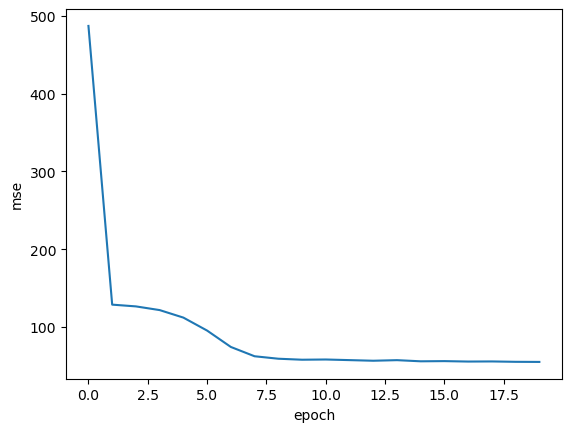

In [50]:
plt.plot(history.history["mse"])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.show()

In [51]:
model.evaluate(X_test,y_test,verbose=2)

53/53 - 0s - loss: 58.1962 - mae: 5.8582 - mse: 58.1962 - 292ms/epoch - 6ms/step


[58.196197509765625, 5.8581695556640625, 58.196197509765625]

In [52]:
predictions = model.predict(X_test)

53/53 [==============================] - 0s 2ms/step


In [54]:
predictions,y_test

(array([[ 3.401119 , 46.943657 ],
        [13.955171 , 55.008316 ],
        [ 1.6839337, 66.54224  ],
        ...,
        [-4.1584444, 60.054497 ],
        [-1.5067028, 58.246445 ],
        [ 0.4708544, 55.828384 ]], dtype=float32),
 array([[10.166667 , 51.333332 ],
        [17.       , 45.5      ],
        [ 3.5      , 63.625    ],
        ...,
        [-2.6666667, 56.75     ],
        [-7.       , 60.875    ],
        [ 7.5      , 51.       ]], dtype=float32))

In [56]:
y_test

array([[10.166667 , 51.333332 ],
       [17.       , 45.5      ],
       [ 3.5      , 63.625    ],
       ...,
       [-2.6666667, 56.75     ],
       [-7.       , 60.875    ],
       [ 7.5      , 51.       ]], dtype=float32)

In [57]:
model1spread = tf.keras.models.Sequential([
    layers.Dense(50,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(50,activation='relu'),
    layers.Dense(1)
])

model1pts = tf.keras.models.Sequential([
    layers.Dense(50,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(50,activation='relu'),
    layers.Dense(1)
])

model1spread.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae','mse'])
model1pts.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae','mse'])

history1spread = model1spread.fit(X_train,y_train[:,0],epochs=20,verbose=1)
history1pts = model1pts.fit(X_train,y_train[:,1],epochs=20,verbose=1)



Epoch 1/20
123/123 [==============================] - 1s 3ms/step - loss: 201.5708 - mae: 11.2609 - mse: 201.5708
Epoch 2/20
123/123 [==============================] - 0s 3ms/step - loss: 174.9489 - mae: 10.4501 - mse: 174.9489
Epoch 3/20
123/123 [==============================] - 0s 3ms/step - loss: 104.1513 - mae: 7.9299 - mse: 104.1513
Epoch 4/20
123/123 [==============================] - 0s 3ms/step - loss: 71.6260 - mae: 6.4621 - mse: 71.6260
Epoch 5/20
123/123 [==============================] - 0s 3ms/step - loss: 71.0309 - mae: 6.4443 - mse: 71.0309
Epoch 6/20
123/123 [==============================] - 0s 3ms/step - loss: 70.2580 - mae: 6.3948 - mse: 70.2580
Epoch 7/20
123/123 [==============================] - 0s 3ms/step - loss: 69.8917 - mae: 6.3696 - mse: 69.8917
Epoch 8/20
123/123 [==============================] - 0s 3ms/step - loss: 69.9855 - mae: 6.3899 - mse: 69.9855
Epoch 9/20
123/123 [==============================] - 0s 3ms/step - loss: 69.4426 - mae: 6.3436 - mse: 6

In [60]:
history1spread = model1spread.fit(X_train,y_train[:,0],epochs=10,verbose=1)
history1pts = model1pts.fit(X_train,y_train[:,1],epochs=10,verbose=1)

Epoch 1/10
123/123 [==============================] - 0s 3ms/step - loss: 67.9658 - mae: 6.2540 - mse: 67.9658
Epoch 2/10
123/123 [==============================] - 0s 3ms/step - loss: 68.3630 - mae: 6.2785 - mse: 68.3630
Epoch 3/10
123/123 [==============================] - 0s 3ms/step - loss: 68.1331 - mae: 6.2887 - mse: 68.1331
Epoch 4/10
123/123 [==============================] - 0s 3ms/step - loss: 68.1247 - mae: 6.2760 - mse: 68.1247
Epoch 5/10
123/123 [==============================] - 0s 3ms/step - loss: 68.2357 - mae: 6.2731 - mse: 68.2357
Epoch 6/10
123/123 [==============================] - 0s 3ms/step - loss: 67.9983 - mae: 6.2671 - mse: 67.9983
Epoch 7/10
123/123 [==============================] - 0s 3ms/step - loss: 67.5774 - mae: 6.2425 - mse: 67.5774
Epoch 8/10
123/123 [==============================] - 0s 3ms/step - loss: 67.3719 - mae: 6.2269 - mse: 67.3719
Epoch 9/10
123/123 [==============================] - 0s 3ms/step - loss: 67.7635 - mae: 6.2660 - mse: 67.7635
E

In [61]:
history1pts = model1pts.fit(X_train,y_train[:,1],epochs=10,verbose=1)

Epoch 1/10
123/123 [==============================] - 0s 3ms/step - loss: 41.0779 - mae: 5.0830 - mse: 41.0779
Epoch 2/10
123/123 [==============================] - 0s 3ms/step - loss: 40.3523 - mae: 5.0330 - mse: 40.3523
Epoch 3/10
123/123 [==============================] - 0s 3ms/step - loss: 40.1018 - mae: 5.0122 - mse: 40.1018
Epoch 4/10
123/123 [==============================] - 0s 3ms/step - loss: 40.5467 - mae: 5.0334 - mse: 40.5467
Epoch 5/10
123/123 [==============================] - 0s 3ms/step - loss: 40.0385 - mae: 5.0132 - mse: 40.0385
Epoch 6/10
123/123 [==============================] - 0s 3ms/step - loss: 40.0525 - mae: 5.0188 - mse: 40.0525
Epoch 7/10
123/123 [==============================] - 0s 3ms/step - loss: 39.6353 - mae: 4.9933 - mse: 39.6353
Epoch 8/10
123/123 [==============================] - 0s 3ms/step - loss: 39.3644 - mae: 4.9724 - mse: 39.3644
Epoch 9/10
123/123 [==============================] - 0s 3ms/step - loss: 39.2886 - mae: 4.9589 - mse: 39.2886
E

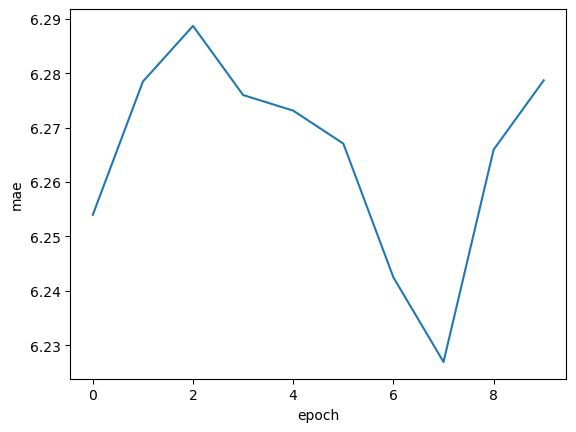

In [67]:
plt.plot(history1spread.history["mae"])
plt.gca().set(xlabel="epoch",ylabel="mae")
plt.show()

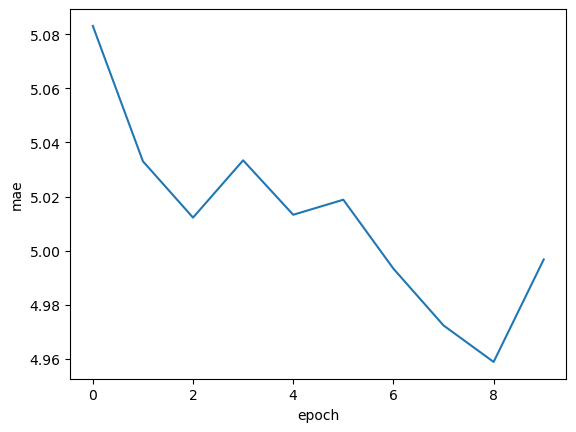

In [66]:
plt.plot(history1pts.history["mae"])
plt.gca().set(xlabel="epoch",ylabel="mae")
plt.show()

In [68]:
model1spread.evaluate(X_test,y_test[:,0],verbose=2)

53/53 - 0s - loss: 74.9795 - mae: 6.4698 - mse: 74.9795 - 410ms/epoch - 8ms/step


[74.97950744628906, 6.469763278961182, 74.97950744628906]

In [69]:
model1pts.evaluate(X_test,y_test[:,1],verbose=1)

53/53 [==============================] - 1s 5ms/step - loss: 41.2294 - mae: 5.0792 - mse: 41.2294


[41.229434967041016, 5.079164028167725, 41.229434967041016]

In [70]:
predictions1spread = model1spread.predict(X_test)
predictions1pts = model1pts.predict(X_test)

53/53 [==============================] - 0s 5ms/step


In [73]:
predictions1spread,y[:,0]

(array([[ 1.5508249 ],
        [13.12046   ],
        [ 0.11792536],
        ...,
        [-6.085545  ],
        [-2.958588  ],
        [-0.8835853 ]], dtype=float32),
 array([  2.      ,  12.666667, -20.833334, ...,  -7.25    ,  15.625   ,
         -2.625   ], dtype=float32))

In [74]:
predictions1pts,y[:,1]

(array([[45.406204],
        [52.552258],
        [65.665535],
        ...,
        [58.60417 ],
        [57.936844],
        [53.890133]], dtype=float32),
 array([62.  , 44.25, 57.75, ..., 64.  , 53.75, 32.  ], dtype=float32))